In [1]:
import pandas as pd
import numpy as np
import json


from langdetect import detect
from matplotlib import pyplot as plt

from contextualized_topic_models.models.ctm import ZeroShotTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("D:\commoncrawl\sample.csv")
df.dropna(inplace=True)
len(df)
# COLUMNS = 'title', 'maintext', 'date_publish', 'language', 'source_domain', 'id'

289518

In [3]:
df_en = pd.read_csv(r"D:\outputs\alldata_fiveclass_2.csv")
df_en.dropna(inplace=True)
df_en.head()

,text,clean_text,media_outlet,year,label
0,Battling to save the worlds bananas Visiting t...,Battling to save the worlds bananas Visiting t...,bbc,2018,center
1,"Escape from the asylum In Croatia, thousands o...","Escape from the asylum In Croatia, thousands o...",bbc,2018,center
2,Trump erroneously claims he had record viewers...,Trump erroneously claims he had record viewers...,businessinsider,2018,lean left
3,Trump slams Democrats for doing nothing while ...,Trump slams Democrats for doing nothing while ...,businessinsider,2018,lean left
4,Cartoon Ghost Story of the Union Site content ...,Cartoon Ghost Story of the Union Site content ...,dailykos,2018,left


In [4]:
import random
random.seed(42)
sample = random.sample([x for x in enumerate(df_en.clean_text.to_numpy())], 10000)
documents = {str(row[0]): row[1][:512] for row in sample}
print(len(documents), "total english documents")

10000 total english documents


In [5]:
sp = WhiteSpacePreprocessing(list(documents.values()), stopwords_language='english')
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()

In [6]:
tp = TopicModelDataPreparation("distiluse-base-multilingual-cased")

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

# TODO provare 5 e 8
num_topics = 8
ctm = ZeroShotTM(bow_size=len(tp.vocab), contextual_size=512, n_components=num_topics, num_epochs=20)
ctm.fit(training_dataset) # run the model

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: [20/20]	 Seen Samples: [200000/200000]	Train Loss: 224.16992524414061	Time: 0:00:14.482189: : 20it [04:55, 14.79s/it]


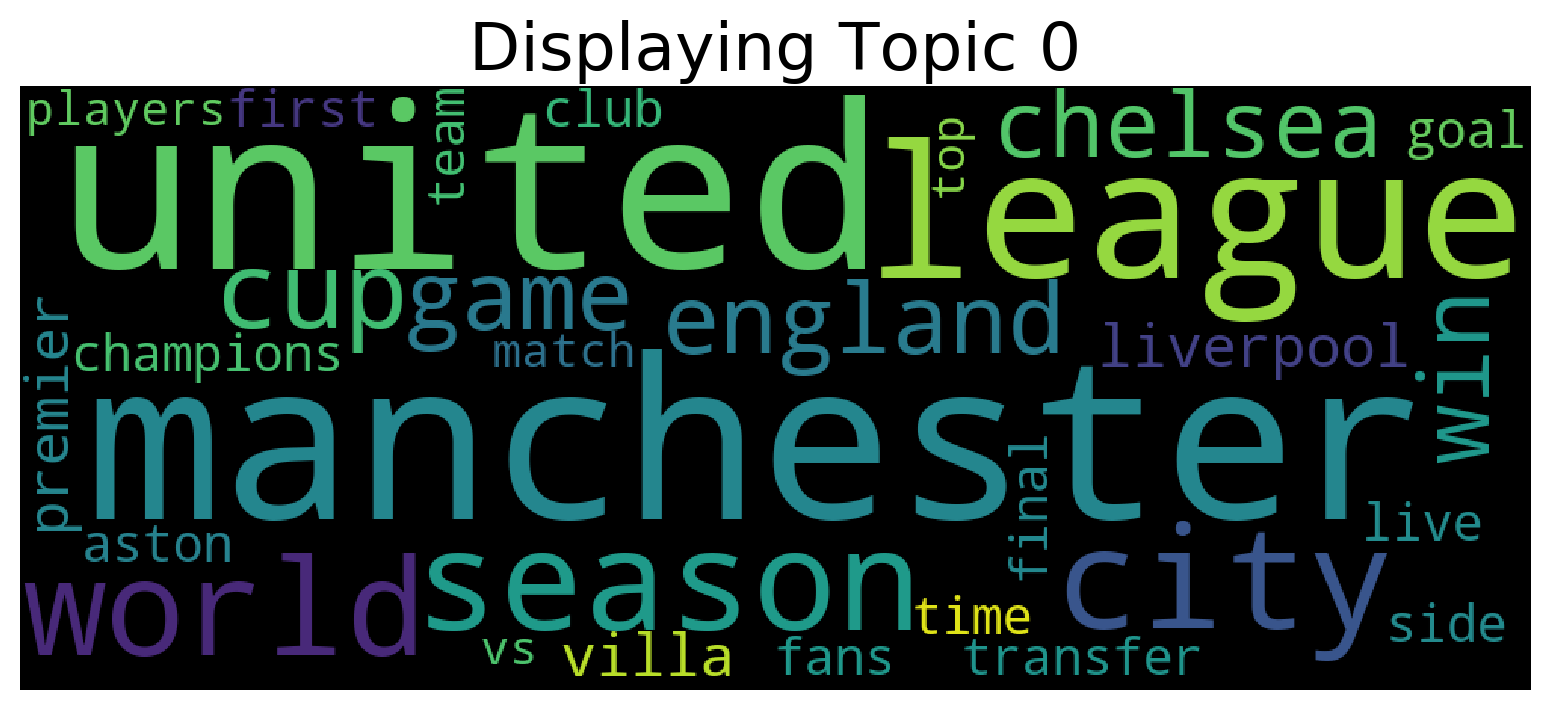

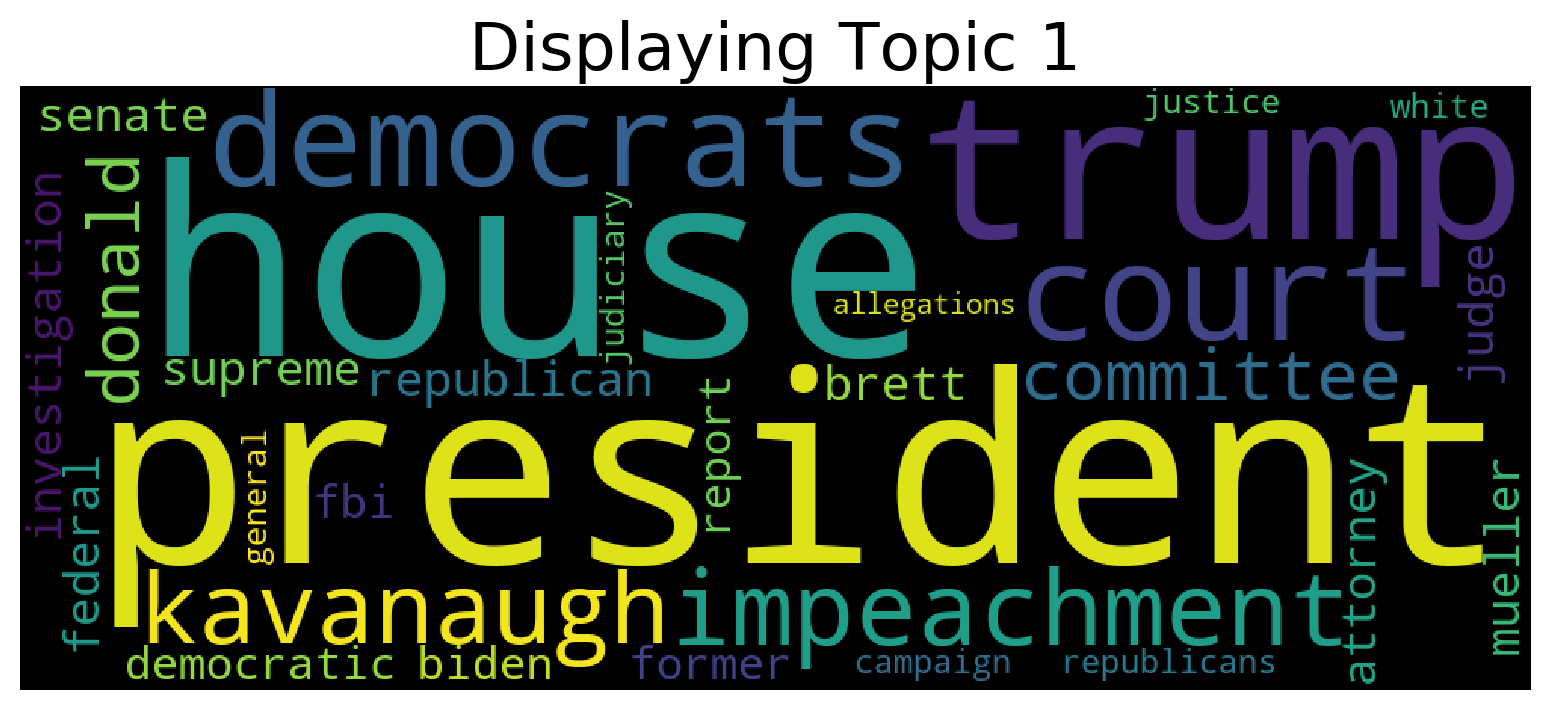

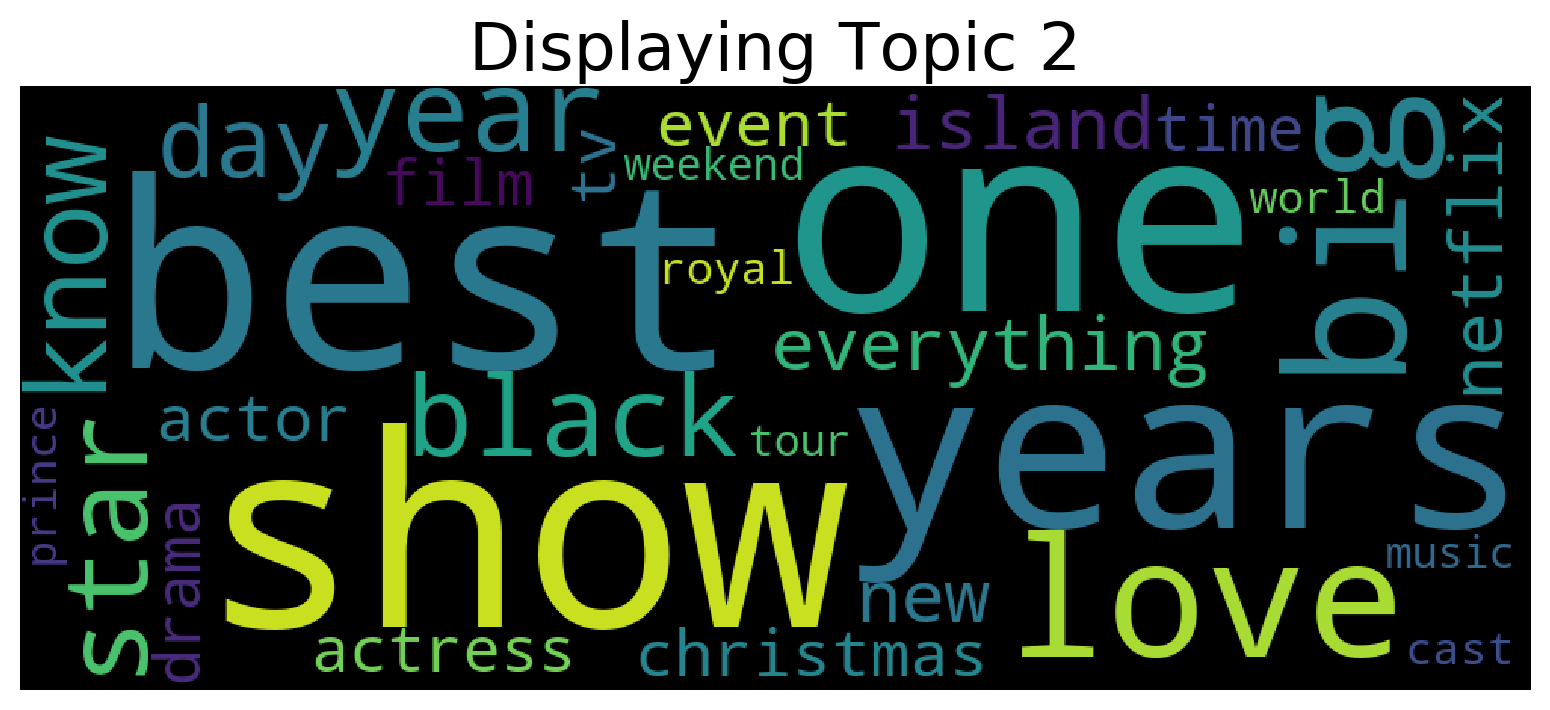

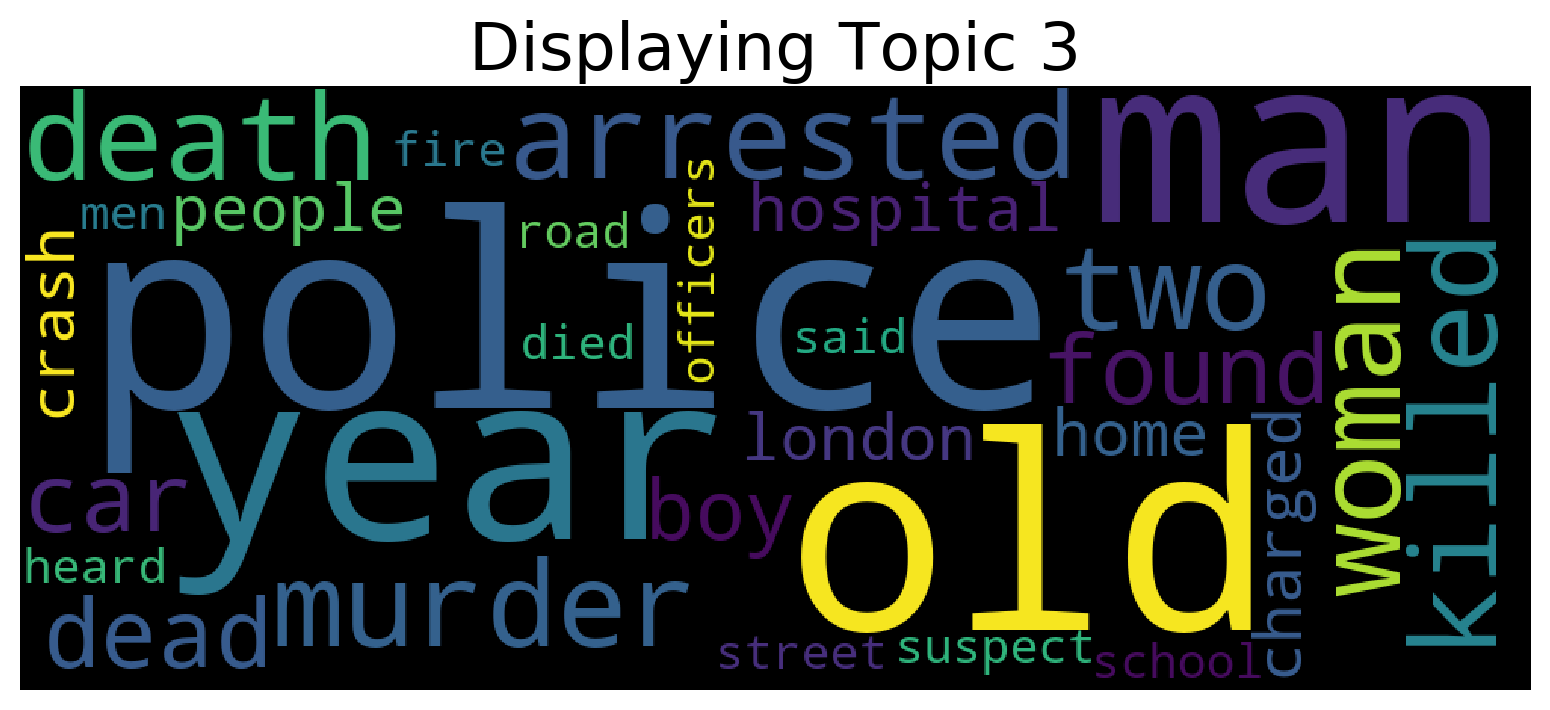

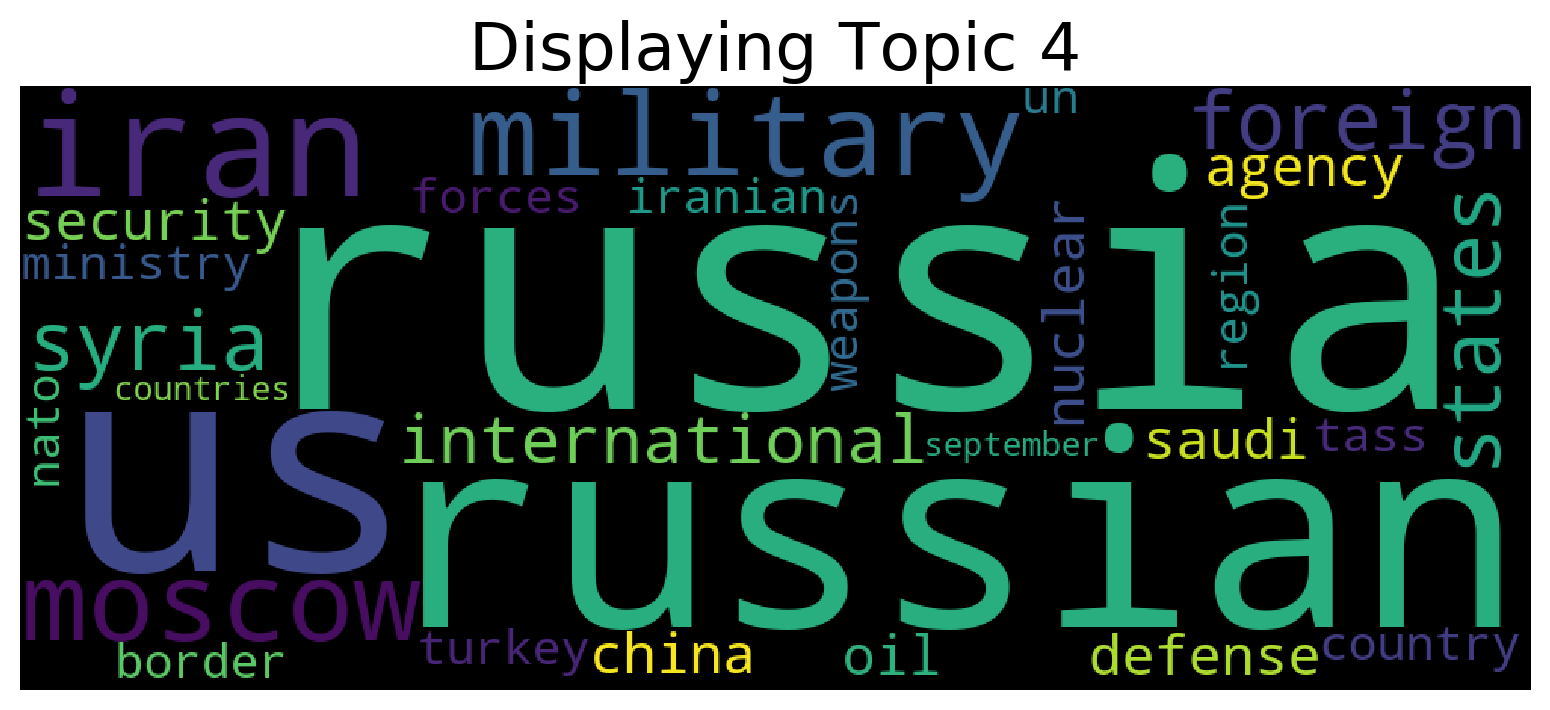

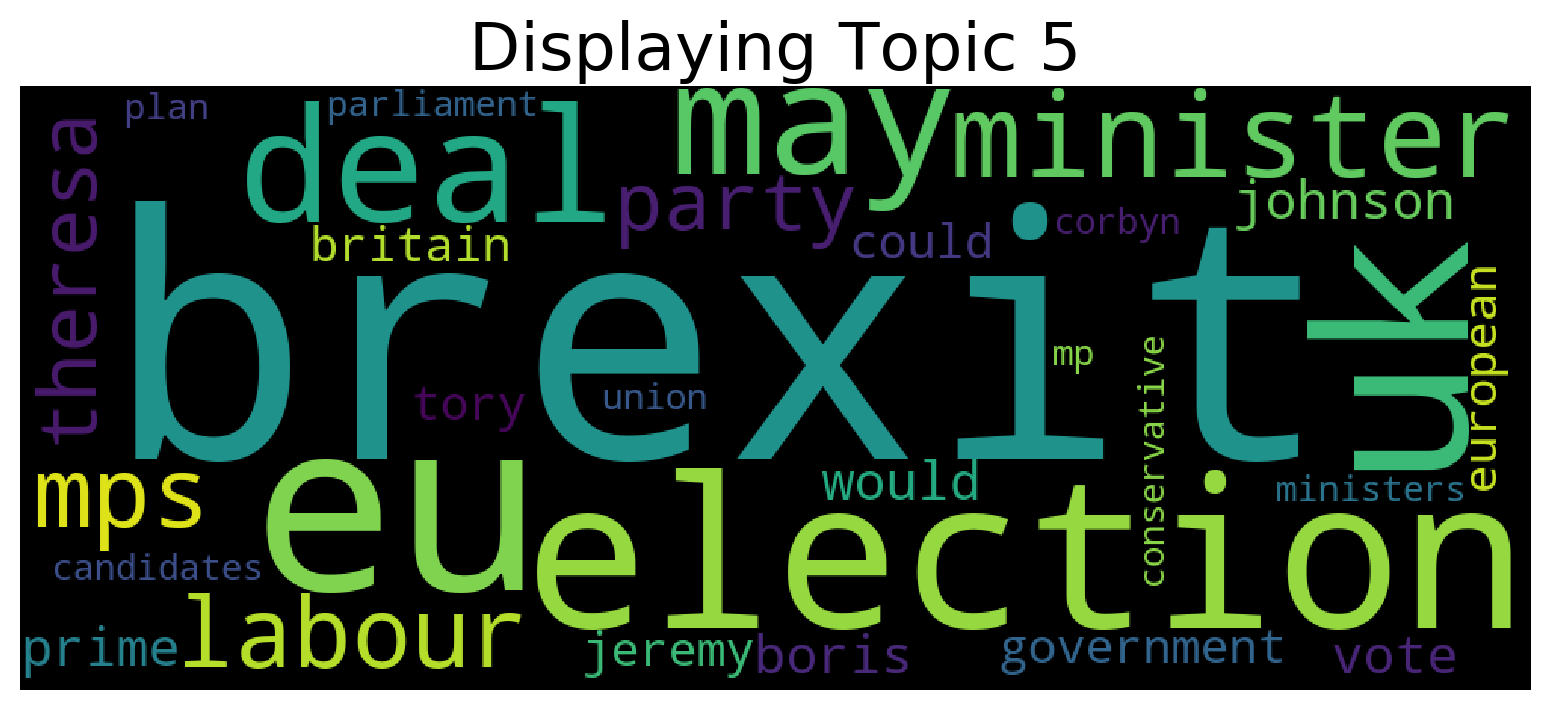

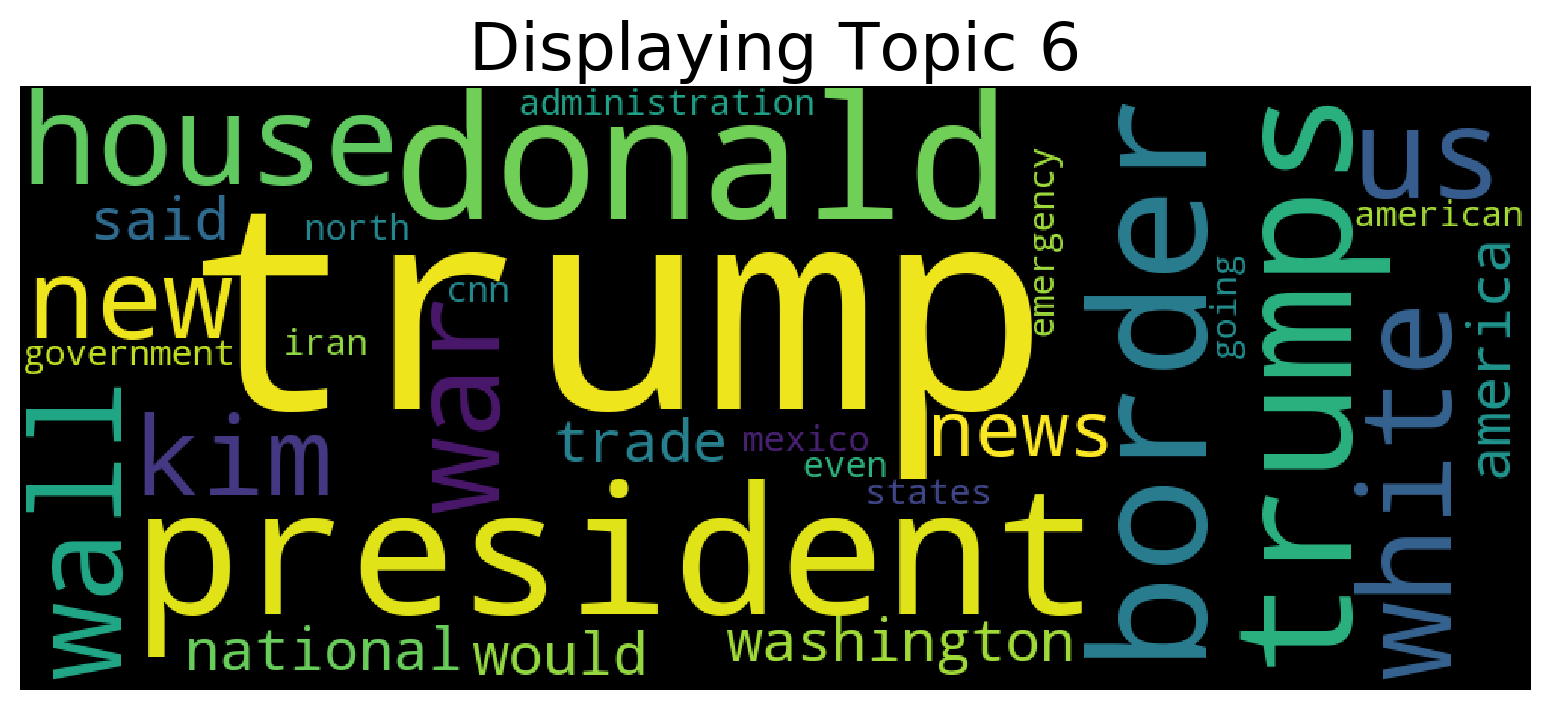

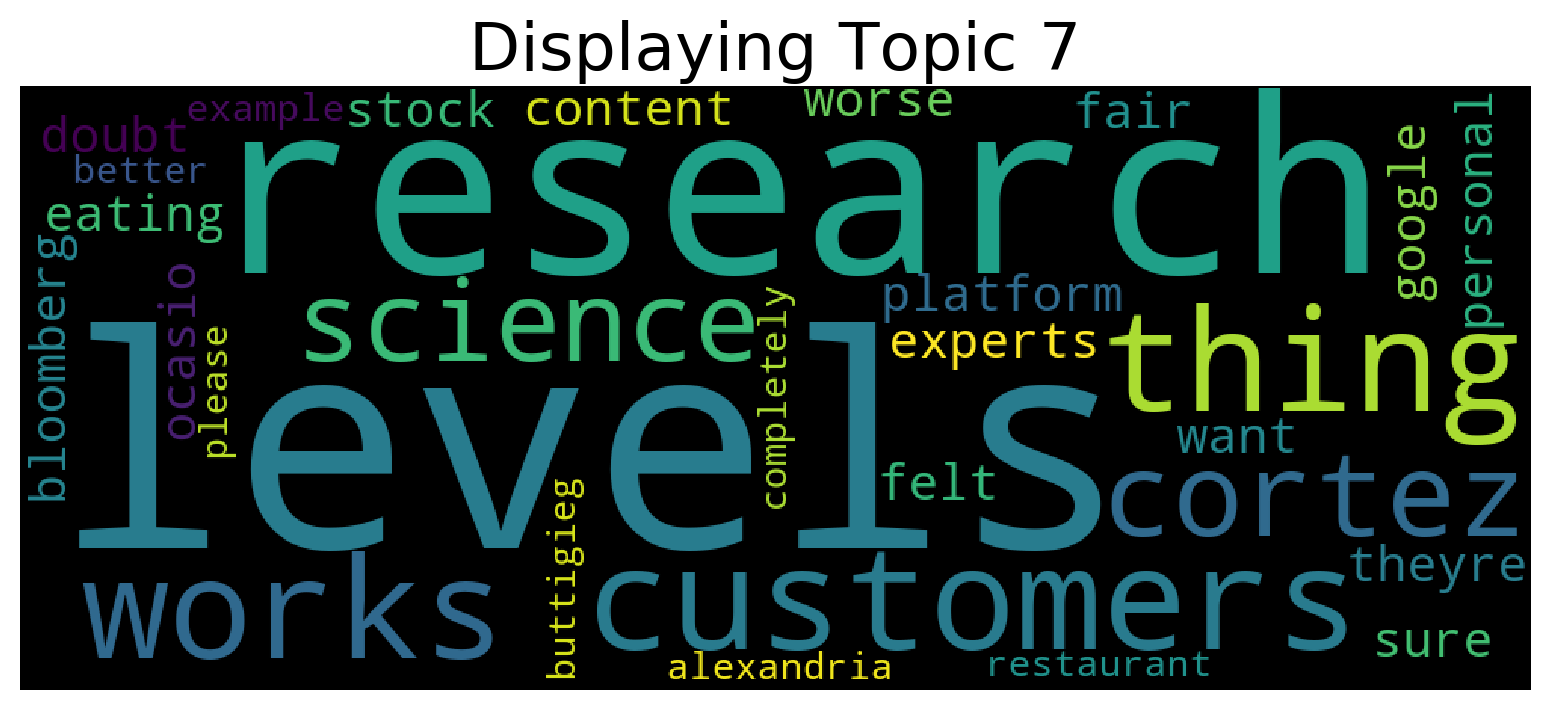

In [7]:
%matplotlib inline
for i in range(num_topics):
    ctm.get_wordcloud(topic_id=i, n_words=30)
    #filename = 'wordclouds/topic{}.png'.format(i)
    #plt.savefig(filename, bbox_inches='tight')

In [8]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=30)

Sampling: [30/30]: : 30it [06:38, 13.29s/it]


In [9]:
import pyLDAvis as vis
movies_pd = vis.prepare(**lda_vis_data)
vis.display(movies_pd)

In [10]:
italian_documents = [a[:512] for a in df[df['language'] == 'it'].maintext if detect(a) == 'it'][:1000]
len(italian_documents)

C:\Users\loren\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1000

In [11]:
testing_dataset = tp.transform(italian_documents)
italian_topics_predictions = ctm.get_thetas(testing_dataset, n_samples=5) # get all the topic predictions

C:\Users\loren\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\loren\anaconda3\envs\news\lib\site-packages\contextualized_topic_models\utils\data_preparation.py:84: UserWarning: The method did not have in input the text_for_bow parameter. This IS EXPECTED if you are using ZeroShotTM in a cross-lingual setting
  warnings.warn("The method did not have in input the text_for_bow parameter. This IS EXPECTED if you "


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
for i in range(0, 50):
    print(italian_documents[i])
    topic_number = np.argmax(italian_topics_predictions[i]) # get the topic id of the first document
    print(ctm.get_topic_lists(10)[topic_number])
    print("==========================================")